# Docker BRATS results

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import seaborn as sb
from pprint import pprint
%matplotlib inline

In [207]:
# set up the variables and environment
met = 'at'
#set baseline variables for export and stuff
res = 400 # dpi value for image export
form = 'png' #image format for matplotlib exports
filename = met + '_dice_scores.csv'
#rename colums to their 3 character IDs
candidates = {
        'aju' : 'tumor_istb_aj_class.nii',
        'aca' : 'data_data_prediction.nii.gz',
        'kch' : 'tumor_qtimlab_class.nii.gz',
        'ekr' : 'tumor_00000000_class.nii.gz',
        'aka' : 'tumor_kamleshp_class.nii.gz',
        'mag' : 'tumor_magnrbm_class.nii',
        'sse' : 'tumor_saras_tb_class.nii.gz',
        'rsa': 'tumor_gevaertlab_class.nii',
        'gwa' : 'brats_dc_brats2016_test_klhd_pat101_3.nii.gz',
        'ise' : 'tumor_brats2017_isensee_class.nii.gz',
        'mav' : 'majvote_fusion.nii.gz',
        'none' : 'default'
    }
#invert the indices to assign the proper labels
inv_cand = {v: k for k, v in candidates.items()}

In [208]:
#import data
data = pandas.read_csv(filename)
#preprocess data
#data = data.drop('Unnamed: 0', axis=1)
#data = data.rename(inv_cand, axis=1)

In [209]:
# remove every 2nd row (unnecessary column heads)
clean = data.iloc[::2]
# remove patient name column
clean = clean.drop('patient', axis=1)
# rename columns to 3 digit ID
clean = clean.rename(inv_cand, axis=1)
clean.to_csv(met+'_clean.csv')

In [210]:
# read a clean copy of the preprocessed csv again
data = pandas.read_csv(met+'_clean.csv')
# remove wrong row indices
data = data.drop('Unnamed: 0', axis=1)

In [211]:
#sort the indices by their mean value and reorder the data frame for descending plotting
m = data.mean()
m_sorted = m.sort_values(ascending=False)
print('Mean values sorted:')
pprint(m_sorted)
print('\nMedian sorted:')
pprint(data.median().sort_values(ascending=False))
print('\nStandard deviation sorted:')
pprint(data.std().sort_values(ascending=True))
indices = m_sorted.keys()
# order dataframe by mean
indices = indices.tolist()
wt_ordered = data[indices]

Mean values sorted:
mav    0.536238
ise    0.530781
aju    0.520485
kch    0.513458
ekr    0.501116
rsa    0.480700
aca    0.477822
gwa    0.442636
aka    0.435304
mag    0.370510
dtype: float64

Median sorted:
mav    0.693227
ise    0.691628
kch    0.670936
aju    0.668524
ekr    0.668031
aca    0.621182
rsa    0.617984
gwa    0.555813
aka    0.551763
mag    0.435163
dtype: float64

Standard deviation sorted:
mag    0.304030
gwa    0.308650
aka    0.313537
aca    0.323025
aju    0.334573
rsa    0.334854
ise    0.338413
kch    0.338730
mav    0.340091
ekr    0.340406
dtype: float64


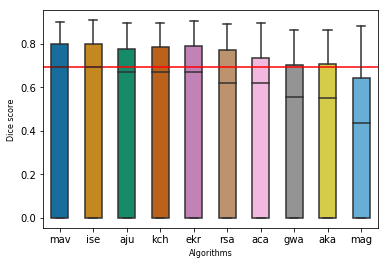

In [212]:
# fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bplot = sb.boxplot(data=wt_ordered, 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=8)
bplot.set_ylabel('Dice score', fontsize=8)
bplot.hlines(np.max(data.median()), -100, 1000, colors='r')
#save the plot
bplot.figure.savefig(met+'_fullplot.png', format=form, dpi=res)

Text(16.200000000000003, 0.5, 'Dice score')

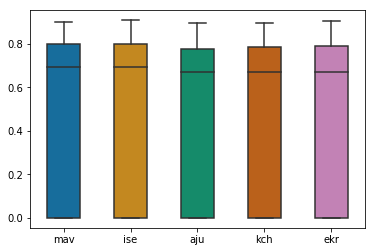

In [213]:
results = np.split(wt_ordered, [5], axis=1)
bplot1 = sb.boxplot(data=results[0], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot1.set_xlabel('Algorithms', fontsize=14)
bplot1.set_ylabel('Dice score', fontsize=14)

Text(16.200000000000003, 0.5, 'Dice score')

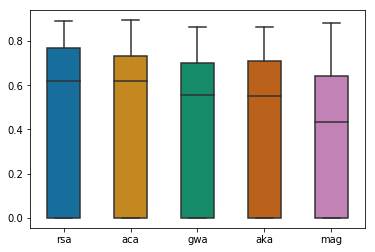

In [214]:
bplot2 = sb.boxplot(data=results[1], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot2.set_xlabel('Algorithms', fontsize=14)
bplot2.set_ylabel('Dice score', fontsize=14)

In [215]:
#save all of it
bplot1.figure.savefig(met+'_boxplot1.png', format=form, dpi=res)
bplot2.figure.savefig(met+'_boxplot2.png', format=form, dpi=res)